In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<h5>Rough Draft</h5>

Types of models to use :
* Linear Regression (Check if underfit with plots)
    - Log transform skewed distributions
* KNN
* XGBoost
* https://automl.github.io/auto-sklearn/master/

How to finetune model:
* param grid tuning
* Cross Validation
* K Best features
* R-squared, Adjusted R-squared

How to interpret model:
* Feature Importance
* Permutation Importance
* SHAP values and plots
* Partial Dependence Plots (1 and 2D)



GroupKFold (K = 4, Group by country, then remove country)

Pipeline (Scale, PCA)

In [2]:
# df = pd.read_csv('../data/interim/selected_features.csv',index_col=[0])
# poverty_features = pd.read_csv('../data/interim/poverty_features.csv',index_col=[0])

# X = pd.concat([df,poverty_features],axis=1).drop(['Gini index','Country Name'],axis=1).to_numpy()

df = pd.read_csv('../data/interim/radius3_selected_features.csv',index_col=[0])
X = df.drop(['Gini index','Country Name'],axis=1).to_numpy()

y = df['Gini index'].to_numpy()
groups = df['Country Name'].to_numpy()

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

def preprocess(n_folds):

    group_kfold = GroupKFold(n_splits=n_folds)
    folds = group_kfold.split(X,y,groups)

    transformed = []
    
    for i in range(n_folds):
        train_ind, test_ind = next(folds)
        
        X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[test_ind], y[test_ind]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        pca = PCA(n_components=2)
        X_train_poverty = pca.fit_transform(X_train[:,14:])
        X_test_poverty = pca.transform(X_test[:,14:]) # type: ignore

        X_train = X_train[:,:14]
        X_test = X_test[:,:14] # type: ignore
        
        X_train = np.concatenate((X_train,X_train_poverty),axis=1)
        X_test = np.concatenate((X_test,X_test_poverty),axis=1)
        

        transformed.append(((X_train,X_test),(y_train,y_test)))
    return transformed

        

        
        
         
        
    

        



In [4]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()

train_scores = []
test_scores = []


for Xi,yj in preprocess(5):

    X_train,X_test = Xi
    y_train,y_test = yj

    ols.fit(X_train,y_train)
    train_scores.append(ols.score(X_train,y_train))
    test_scores.append(ols.score(X_test,y_test))

In [5]:
np.average(train_scores)

0.6792726342027681

In [6]:
np.average(test_scores)

0.13916719934698465

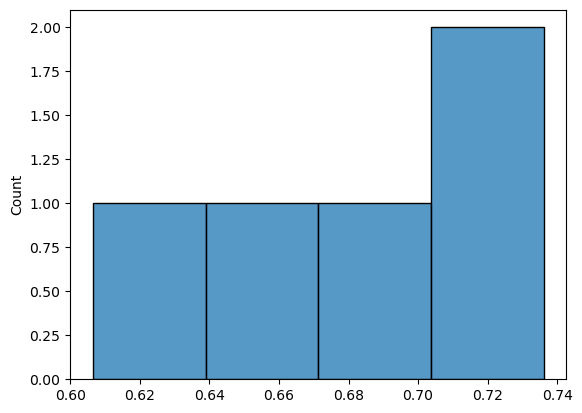

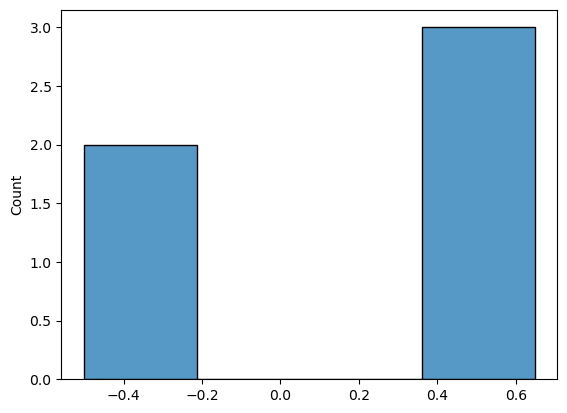

In [7]:
sns.histplot(train_scores)
plt.show()
sns.histplot(test_scores)
plt.show()

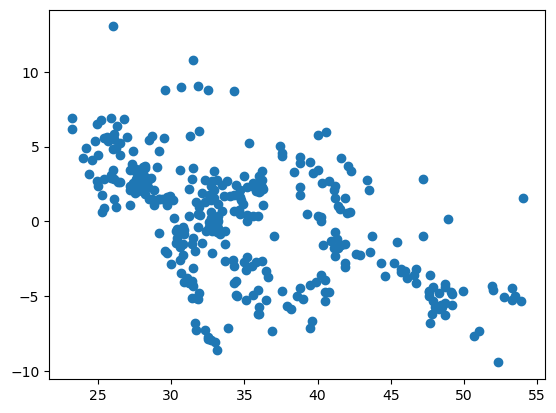

In [8]:
pred = ols.predict(X_train)

plt.scatter(x=y_train,y=pred-y_train)

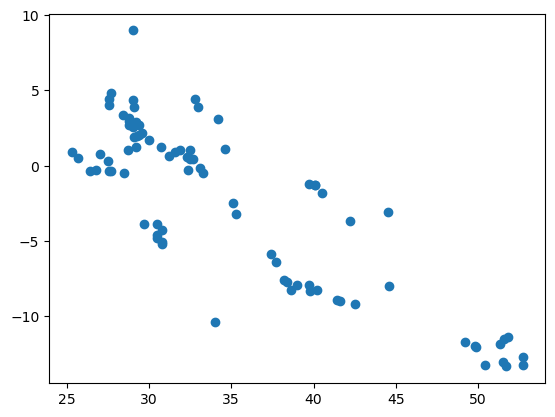

In [9]:
pred = ols.predict(X_test)

plt.scatter(x=y_test,y=pred-y_test)

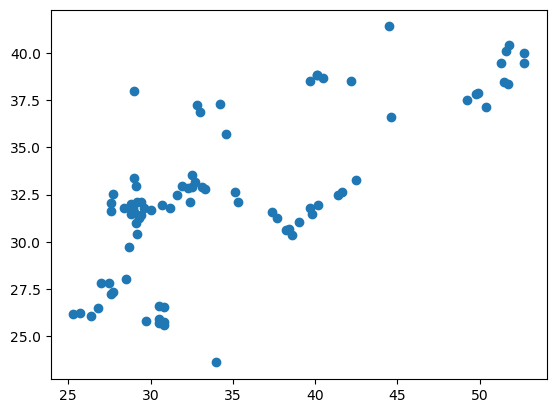

In [10]:
plt.scatter(x=y_test,y=pred)

In [11]:
from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor() #n_neighbors=5,weights='uniform'

for Xi,yj in preprocess(5):
    train_scores = []
    test_scores = []
    X_train,X_test = Xi
    y_train,y_test = yj

    KNN.fit(X_train,y_train)
    print('train score:',KNN.score(X_train,y_train))
    print('test score:',KNN.score(X_test,y_test))

train score: 0.9499144997329038
test score: 0.19417288567002955
train score: 0.9481185194326149
test score: 0.5871974979888981
train score: 0.930495727319378
test score: 0.8580039004288895
train score: 0.9531591757731702
test score: 0.15424566308719645
train score: 0.9367670333763234
test score: 0.6546830430682309


In [12]:
avg_train_scores = []
avg_test_scores = []
nn_range = range(2,20)

for nn in nn_range:
    train_scores = []
    test_scores = []
    KNN = KNeighborsRegressor(n_neighbors=nn,weights='uniform')

    for Xi,yj in preprocess(5):

        X_train,X_test = Xi
        y_train,y_test = yj

        KNN.fit(X_train,y_train)
        train_scores.append(KNN.score(X_train,y_train))
        test_scores.append(KNN.score(X_test,y_test))
    avg_train_scores.append(np.average(train_scores))
    avg_test_scores.append(np.average(test_scores))

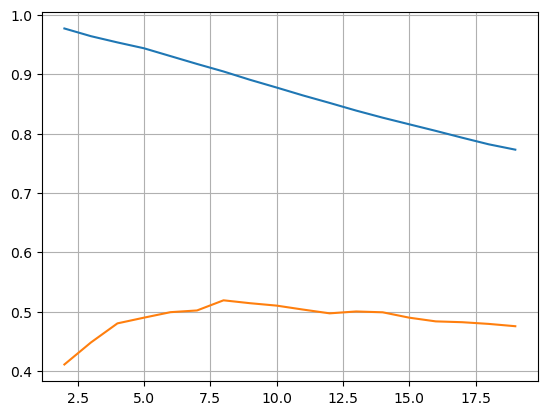

In [13]:
plt.plot(nn_range,avg_train_scores) # type: ignore
plt.plot(nn_range,avg_test_scores) # type: ignore
plt.grid(True)
plt.show()

In [14]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline

avg_train_scores = []
avg_test_scores = []

pipeline = Pipeline(steps=[('skb',SelectKBest()),('knn',KNeighborsRegressor())])

for k_val in range(1,16):
    
    model = pipeline.set_params(skb__k=k_val,skb__score_func=mutual_info_regression,knn__n_neighbors=5)
    
    train_scores = []
    test_scores = []

    for Xi,yj in preprocess(5):

        X_train,X_test = Xi
        y_train,y_test = yj

        model.fit(X_train,y_train)
        train_scores.append(model.score(X_train,y_train))
        test_scores.append(model.score(X_test,y_test))
    avg_train_scores.append(np.average(train_scores))
    avg_test_scores.append(np.average(test_scores))
    

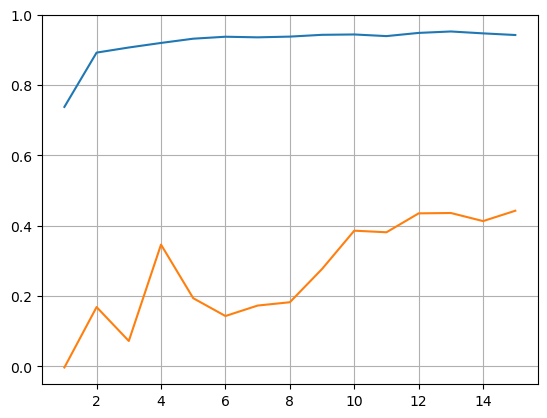

In [15]:
plt.plot(range(1,16),avg_train_scores) # type: ignore
plt.plot(range(1,16),avg_test_scores) # type: ignore
plt.grid(True)
plt.show()


In [16]:
df.head()

,Year,"Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)","Educational attainment, Doctoral or equivalent, population 25+, total (%) (cumulative)","Inflation, consumer prices (annual %)",GDP (current US$),"Cause of death, by injury (% of total)","Educational attainment, at least Master's or equivalent, population 25+, total (%) (cumulative)","Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)","Population, total","Unemployment, total (% of total labor force) (modeled ILO estimate)",...,"Physicians (per 1,000 people)",Country Name,Gini index,Poverty headcount ratio at $3.65 a day (2017 PPP) (% of population),Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),Poverty gap at $2.15 a day (2017 PPP) (%),Poverty gap at $3.65 a day (2017 PPP) (%),Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population),Poverty gap at $6.85 a day (2017 PPP) (%),GDP per capita
11420,2002,88.543221,0.00000,0.757421,4.395616e+10,8.507397,16.28310,38.141708,48202470.0,10.140,...,3.0188,Ukraine,29.0,17.0,61.9,0.5,3.7,2.7,20.8,911.906871
11686,2003,88.543221,0.00000,5.179678,5.201035e+10,8.507397,16.28310,38.141708,47812949.0,9.060,...,3.0096,Ukraine,28.7,10.4,54.1,0.2,2.1,1.1,16.0,1087.788007
12624,2007,95.692841,0.03193,10.230103,3.802571e+09,10.150055,15.44759,17.622650,5268400.0,2.677,...,2.3580,Kyrgyz Republic,33.9,33.6,74.2,1.7,9.5,8.8,31.8,721.769526
12687,2007,61.490292,0.25529,4.168633,2.129598e+10,12.359977,2.37209,21.358910,3431614.0,5.844,...,1.3032,Panama,52.7,14.9,30.5,2.2,5.7,6.7,13.6,6205.821576
12879,2008,80.522840,0.79249,4.060305,2.754475e+11,5.055017,9.20796,30.182824,4489544.0,6.770,...,4.0144,Ireland,30.9,0.3,0.8,0.1,0.2,0.2,0.4,61353.106563


In [17]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.feature_selection import f_regression,r_regression


# group_k_fold = GroupKFold(n_splits=5)

# params = {
#     'skb__k':range(1,16),
#     'skb__score_func':[mutual_info_regression,f_regression,r_regression],
#     'knn__n_neighbors':range(5,100,5),
#     'knn__weights':['uniform','distance'],
#     'knn__p':[1,2,3]
# }

# gsc = GridSearchCV(pipeline,params,scoring='r2',cv=group_k_fold)

# results = gsc.fit(X,y,groups=groups)


In [18]:
from sklearn.feature_selection import f_regression,r_regression,mutual_info_regression
pipeline = Pipeline(steps=[('skb',SelectKBest()),('knn',KNeighborsRegressor())])
params = {
    'skb__k':range(1,16),
    'skb__score_func':[mutual_info_regression,f_regression,r_regression],
    'knn__n_neighbors':range(5,100,5),
    'knn__weights':['uniform','distance'],
    'knn__p':[1,2,3]
}

best_score = -3
best_params = {
    'skb__k':0,
    'skb__score_func':0,
    'knn__n_neighbors':0,
    'knn__weights':0,
    'knn__p':0
}

for k in params['skb__k']:
    for skb_score_func in params['skb__score_func']:
        for n_neighbors in params['knn__n_neighbors']:
            for knn_weights in params['knn__weights']:
                for knn_p in params['knn__p']:
                    test_scores = []
                    for Xi,yj in preprocess(5):

                        X_train,X_test = Xi
                        y_train,y_test = yj
                        pipeline = Pipeline(steps=[('skb',SelectKBest()),('knn',KNeighborsRegressor())])
                        pipeline.set_params(skb__k=k,knn__n_neighbors=n_neighbors,knn__weights=knn_weights,knn__p=knn_p)

                        pipeline.fit(X_train,y_train)
                        test_scores.append(pipeline.score(X_test,y_test))
                    if np.average(test_scores) > best_score: # type: ignore
                        best_score = np.average(test_scores)
                        best_params = {
                                'skb__k':k,
                                'skb__score_func':skb_score_func,
                                'knn__n_neighbors':n_neighbors,
                                'knn__weights':knn_weights,
                                'knn__p':knn_p
                            } 


In [19]:
best_score

0.5966573527621419

In [20]:
best_params

{'skb__k': 13,
 'skb__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_regression(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>,
 'knn__n_neighbors': 10,
 'knn__weights': 'uniform',
 'knn__p': 1}

In [21]:
avg_train_scores = []
avg_test_scores = []

pipeline = Pipeline(steps=[('skb',SelectKBest()),('knn',KNeighborsRegressor())])

for k_val in range(1,14):
    
    model = pipeline.set_params(skb__k=k_val,skb__score_func=mutual_info_regression,knn__n_neighbors=10,knn__weights='distance',knn__p=1)
    
    train_scores = []
    test_scores = []

    for Xi,yj in preprocess(5):

        X_train,X_test = Xi
        y_train,y_test = yj

        model.fit(X_train,y_train)
        train_scores.append(model.score(X_train,y_train))
        test_scores.append(model.score(X_test,y_test))
    avg_train_scores.append(np.average(train_scores))
    avg_test_scores.append(np.average(test_scores))

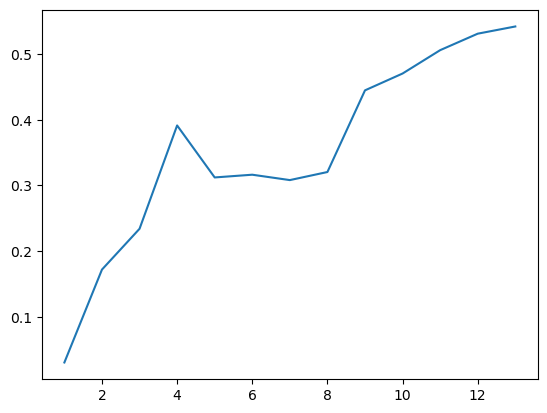

In [22]:
plt.plot(range(1,14),avg_test_scores) # type: ignore

In [30]:
skb = SelectKBest(score_func=mutual_info_regression,k=11)
columns = df.drop(['Country Name', 'Gini index'],axis=1).columns.to_list()
feature_names = [col for col in columns if col.find('Poverty') < 0]
feature_names.append('poverty_pca0')
feature_names.append('poverty_pca1')

best_features = []

for Xi,yj in preprocess(5):

    X_train,X_test = Xi
    y_train,y_test = yj

    

    skb.fit(np.concatenate((X_train,X_test),axis=0),np.concatenate((y_train,y_test),axis=0))
    best_features.append(skb.get_feature_names_out(feature_names))  # type: ignore

In [31]:
best_features[0]

array(['Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)',
       'Educational attainment, Doctoral or equivalent, population 25+, total (%) (cumulative)',
       'Cause of death, by injury (% of total)',
       "Educational attainment, at least Master's or equivalent, population 25+, total (%) (cumulative)",
       'Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)',
       'Hospital beds (per 1,000 people)',
       'Life expectancy at birth, total (years)',
       'Physicians (per 1,000 people)', 'GDP per capita', 'poverty_pca0',
       'poverty_pca1'], dtype=object)

In [32]:
model = pipeline.set_params(knn__n_neighbors = 10,knn__p=1,knn__weights='uniform',skb__k=13,skb__score_func=mutual_info_regression)

train_scores = []
test_scores = []

for Xi,yj in preprocess(5):

    X_train,X_test = Xi
    y_train,y_test = yj

    model.fit(X_train,y_train)
    train_scores.append(model.score(X_train,y_train))
    test_scores.append(model.score(X_test,y_test))

In [33]:
print(train_scores)
print(test_scores)

[0.9014324134305989, 0.9075361557089472, 0.8770046521523241, 0.907726817935568, 0.9072647231049638]
[0.3077868311630837, 0.6226496136094708, 0.8506693912908037, 0.4060193647079624, 0.5634566857301933]


In [34]:
skb = SelectKBest(score_func=f_regression,k=3)

# feature_names = df.drop(['Country Name', 'Gini index'],axis=1).columns.to_list()
# feature_names.append('poverty_pca0')
# feature_names.append('poverty_pca1')

best_features = []

for Xi,yj in preprocess(5):

    X_train,X_test = Xi
    y_train,y_test = yj

    

    skb.fit(np.concatenate((X_train,X_test),axis=0),np.concatenate((y_train,y_test),axis=0))
    best_features.append(skb.get_feature_names_out(feature_names)) # type: ignore


In [35]:
best_features[0]

array(['Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)',
       'Cause of death, by injury (% of total)',
       'Hospital beds (per 1,000 people)'], dtype=object)

In [36]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score




train_scores = []
test_scores = []

for Xi,yj in preprocess(5):
    xgb = XGBRegressor(n_estimators=30,max_depth=4)#eval_metric=r2_score
    X_train,X_test = Xi
    y_train,y_test = yj

    xgb.fit(X_train,y_train,)#eval_set=[(X_test, y_test)]
    train_scores.append(xgb.score(X_train,y_train))
    test_scores.append(xgb.score(X_test,y_test))

In [37]:
train_scores

[0.9947332317538222,
 0.9955221893073466,
 0.9947422656917155,
 0.9954098693395268,
 0.9950116880417861]

In [38]:
test_scores

[0.3495564044779058,
 0.6167875849846911,
 0.8123265028343948,
 0.17554201440927264,
 0.6822697224444836]

In [39]:
np.average(test_scores)

0.5272964458301496

In [40]:
pd.Series(xgb.feature_importances_,index=feature_names).sort_values()

Year                                                                                                       0.001566
Inflation, consumer prices (annual %)                                                                      0.003553
Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)    0.004518
Educational attainment, at least Master's or equivalent, population 25+, total (%) (cumulative)            0.006414
Educational attainment, Doctoral or equivalent, population 25+, total (%) (cumulative)                     0.007299
Physicians (per 1,000 people)                                                                              0.008434
Unemployment, total (% of total labor force) (modeled ILO estimate)                                        0.013184
poverty_pca0                                                                                               0.015226
GDP (current US$)                                                       

In [45]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('xgb',XGBRegressor())])  #('rfe',RFE(XGBRegressor())),

param_grid = {
    'xgb__n_estimators':np.arange(150,300),
    'xgb__max_depth':np.arange(3,15),
    # 'xgb__learning_rate':np.arange(0,1,0.1),
    # 'xgb__reg_lambda':np.arange(0,2,0.1),
    # 'xgb__reg_alpha':np.arange(0,1,0.1)
}

keys = list(param_grid.keys())

params_pointer = {
    'xgb__n_estimators':0,
    'xgb__max_depth':0,
    # 'xgb__learning_rate':0,
    # 'xgb__reg_lambda':0,
    # 'xgb__reg_alpha':0
}

global best_score
best_score = -3
global best_params
best_params = {
    #'rfe__n_features_to_select':0,
    'xgb__n_estimators':0,
    'xgb__max_depth':0,
    # 'xgb__learning_rate':0,
    # 'xgb__reg_lambda':0,
    # 'xgb__reg_alpha':0
}

def search_grid(n_vars):
    if n_vars > 0:
        current_key = keys[len(keys)-n_vars]
        for v in param_grid[current_key]:
            params_pointer[current_key] = v
            search_grid(n_vars-1)
    else:
        pipeline = Pipeline([('xgb',XGBRegressor())])
        pipeline.set_params(**params_pointer)
        test_scores = []
        for Xi,yj in preprocess(5):

            X_train,X_test = Xi
            y_train,y_test = yj


            pipeline.fit(X_train,y_train)
            test_scores.append(pipeline.score(X_test,y_test))
        global best_score
        if np.average(test_scores) > best_score: # type: ignore
            best_score = np.average(test_scores)
            print(best_score)
            global best_params
            best_params = params_pointer 

In [46]:
search_grid(2)

0.529655567373055
0.534881304169818


: 

In [ ]:

# for n_estimators in param_grid['xgb__n_estimators']:
#     for max_depth in param_grid['xgb__max_depth']:
#         pp = {
#                 'xgb__n_estimators':n_estimators,
#                 'xgb__max_depth':max_depth,
#             }
#         pipeline.set_params(**pp)
#         test_scores = []
#         for Xi,yj in preprocess(5):

#             X_train,X_test = Xi
#             y_train,y_test = yj


#             pipeline.fit(X_train,y_train)
#             test_scores.append(pipeline.score(X_test,y_test))
        
#         if np.average(test_scores) > best_score: # type: ignore
            
#             best_score = np.average(test_scores)
#             print(best_score)
#             for k in best_params.keys():

#                 best_params[k] = pp[k]

In [43]:
best_params

{'xgb__n_estimators': 199, 'xgb__max_depth': 9}

In [44]:
best_score

0.5366868373076603

In [ ]:
from sklearn.ensemble import RandomForestRegressor



train_scores = []
test_scores = []

for Xi,yj in preprocess(5):
    rf = RandomForestRegressor()
    X_train,X_test = Xi
    y_train,y_test = yj

    rf.fit(X_train,y_train,)#eval_set=[(X_test, y_test)]
    train_scores.append(rf.score(X_train,y_train))
    test_scores.append(rf.score(X_test,y_test))

In [ ]:
train_scores

In [ ]:
test_scores

In [ ]:
np.average(test_scores)

In [ ]:
feature_names